# SpaceCraft Touch-Down Predictor & Analytics

( IBM Data Science Professional Certificate )

**Author: Muhammad Fouzan Akhter**

**Disclaimer:** The code presented here is not owned by me, and there are likely numerous other attempts at the same exercise. This project represents my interpretation and implementation of the IBM Data Science Professional Certificate Capstone Project. All rights are reserved by IBM, and they reserve the right to take down the code or content associated with their materials at their discretion.

Throughout this project, we will engage with real-world datasets, beginning by sourcing raw data from various origins. Our initial focus will be on refining data quality through meticulous data wrangling techniques. Subsequently, we will explore the processed data, utilizing SQL to query and extract meaningful insights. Statistical analysis and data visualization will aid in uncovering relationships between variables, providing a clear visual understanding.

Further exploration will involve segmenting data into categorical groups to gain deeper insights. As we progress, we will develop, assess, and enhance predictive models to extract profound insights from the dataset. Ultimately, our efforts will culminate in creating a comprehensive presentation that effectively communicates our analyses and discoveries through engaging narratives.

Our goal in this project is to predict whether the Falcon 9's first stage will land successfully after launch. This is crucial because SpaceX's reusability is a key factor behind their competitive launch prices. Their website lists Falcon 9 launches at USD 62 million, significantly lower than competitors' $165 million+ offerings. Predicting a successful first-stage landing would effectively determine the launch cost, providing valuable information for companies considering competing with SpaceX.

**Following is an Example of a Successful Landing:**

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/lab_v2/images/landing_1.gif" alt="landing gif" align="left" style="border: 3px solid black;">


## Importing Libraries and Defining Auxiliary Functions:

In [1]:
response = input("Do you want to install the required libraries? (y/n): ").lower()
if response == "y":
    !pip install pandas
    !pip install numpy
    !pip install python-dateutil
    !pip install ipython
    !pip install pycsv sqlite
    !pip install scikit-learn
    !pip install seaborn matplotlib
    !pip install folium
    !pip install jupyter-dash dash
    !pip install plotly
    !pip install ipython-sql
    !pip install sqlalchemy==1.3.9
    print("All libraries installed successfully.")
elif response == "n":
    print("No libraries were installed.")
else:
    print("Invalid input. Please enter 'yes' or 'no'.")

Do you want to install the required libraries? (y/n): n
No libraries were installed.


In [2]:
import warnings
def warn (*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore")

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import numpy as np
import datetime
from IPython.display import FileLink
import csv
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import io
import folium
from folium.plugins import MarkerCluster, MousePosition
from folium.features import DivIcon
from math import sin, cos, sqrt, atan2, radians
from jupyter_dash import JupyterDash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, jaccard_score, f1_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

**Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data:**

- From the `rocket` column, we would like to learn the booster name.
- From the `launchpad`, we would like to know the name of the launch site being used, the longitude, and the latitude.
- From the `payload`, we would like to learn the mass of the payload and the orbit that it is going to.
- From `cores`, we would like to learn the outcome of the landing, the type of the landing, the number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core (which is a number used to separate versions of cores), the number of times this specific core has been reused, and the serial of the core.


In [4]:
def getBoosterVersion(data):
    for x in data['rocket']:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])
        
def getLaunchSite(data):
    for x in data['launchpad']:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])
        
def getPayloadData(data):
    for load in data['payloads']:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])
        
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Let's begin requesting rocket launch data from the SpaceX API using the provided URL. Then we'll examine the contents of the response. You'll find that the response contains extensive information regarding SpaceX launches. Next we'll uncover additional pertinent details for this project.

In [5]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
user_input = input("Do you want to print the response content?")
if user_input.lower() in ["yes", "y"]:
    print(response.content)
elif user_input.lower() in ["no", "n"]:
    print("Response content not printed.")
else:
    print("Invalid input. Please enter 'yes'(y) or 'no'(n).")

Do you want to print the response content?n
Response content not printed.


Let's start by requesting and parsing SpaceX launch data using a GET request. We'll ensure the request returns a 200 status code and then decode the response content as JSON. Afterward, we'll convert it into a Pandas dataframe using `.json_normalize()` and print the first 5 rows of the dataframe.

You might notice that some columns, like `rocket`, contain IDs instead of useful information. To address this, we'll use the API again to fetch details about the launches using these IDs. Here's what we're after:

- Extract the booster name from the `rocket` column.
- Find out the payload mass and orbit from the `payloads` column.
- Get information about the launch site's name, longitude, and latitude from the `launchpad` column.
- Retrieve various details about the landing, such as outcome, type, gridfin usage, core reusability, and more from the `cores` column.

We'll store this extracted data in lists, which we'll then use to create a new dataframe. This approach helps enrich our dataset with additional insights for better analysis.


In [6]:
static_json_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
if response.status_code == 200:
    print("Request successful.")
    data_json = response.json()
    data = pd.json_normalize(data_json)
else:
    print("Failed to retrieve data. Status code:", response.status_code)

Request successful.


In [7]:
# Use function below to print first 5 rows of DataFrame:
#data.head()

In [8]:
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])
data['date'] = pd.to_datetime(data['date_utc']).dt.date
data = data[data['date'] <= datetime.date(2020, 11, 13)]

**Global Variables:**

These functions will apply the outputs globally to the above variables. Let's take a look at the `BoosterVersion` variable. Before applying `getBoosterVersion`, the list is empty:

In [9]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [10]:
# To check whether BoosterVersion  List is empty or not:
BoosterVersion

[]

Applying all of the Functions & Creating a Dataset:

In [11]:
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [12]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [13]:
launch_data = pd.DataFrame.from_dict(launch_dict)
launch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    94 non-null     int64  
 1   Date            94 non-null     object 
 2   BoosterVersion  94 non-null     object 
 3   PayloadMass     88 non-null     float64
 4   Orbit           94 non-null     object 
 5   LaunchSite      94 non-null     object 
 6   Outcome         94 non-null     object 
 7   Flights         94 non-null     int64  
 8   GridFins        94 non-null     bool   
 9   Reused          94 non-null     bool   
 10  Legs            94 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     94 non-null     int64  
 14  Serial          94 non-null     object 
 15  Longitude       94 non-null     float64
 16  Latitude        94 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

Filtering the dataframe to include only Falcon 9 launches. Exclude Falcon 1 launches by filtering the `BoosterVersion` column to retain only Falcon 9 launches. Save the filtered data to the dataframe `data_falcon9` and reset the `FlightNumber` column.

In [14]:
data_falcon9 = launch_data[launch_data['BoosterVersion'] != 'Falcon 1']
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [15]:
data_falcon9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 4 to 93
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     85 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

**Data Wrangling & Dealing with Missing Values:**

In our dataset, some rows contain missing values. Let's address this before proceeding further. The `LandingPad` column will retain `None` values to indicate when landing pads were not used.

First, we'll calculate the mean value for the `PayloadMass` column using the `.mean()` method. Then, we'll use this mean value and the `.replace()` function to replace `np.nan` values in the data with the calculated mean.

After performing this operation, you should observe the number of missing values in the `PayloadMass` column change to zero.

Now, our dataset should have no missing values except for in the `LandingPad` column.

We can proceed by saving the cleaned dataset to a CSV file named `dataset_1.csv` for the next section.

In [16]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [17]:
payload_mass_mean = data_falcon9['PayloadMass'].mean()
data_falcon9['PayloadMass'].replace(np.nan, payload_mass_mean, inplace = True)

*Run the cell below, if you wish to download your dataset:*

In [18]:
data_falcon9.to_csv('dataset_1.csv', index=False)
FileLink('dataset_part_1.csv')

C:\Users\Fouzan Akhter\dataset_part_1.csv

In [19]:
dataset_1 = data_falcon9.copy()

In [20]:
dataset_1.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


**WikiPedia WebScraping:**

We will now perform webscraping to scrape Falcon 9 historical launch records from a Wiki page titled `List of Falcon 9 and Falcon Heavy Launches`:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/Falcon9_rocket_family.svg)

Our goal is to utilize BeautifulSoup to perform web scraping on Falcon 9 launch records. Here's what we aim to achieve:

- Extract a Falcon 9 launch records HTML table from Wikipedia.
- Parse the table and convert it into a Pandas dataframe.

Additionally, some helper functions will be defined to assist in processing the web scraped HTML table.

In [21]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    

To maintain consistency in lab tasks, we're required to scrape data from a snapshot of the "List of Falcon 9 and Falcon Heavy launches" Wikipedia page updated on 9th June 2021.

Firstly, we'll request the HTML page from the specified URL and obtain a response object. Subsequently, we'll perform an HTTP GET method to request the Falcon 9 Launch HTML page and create a `BeautifulSoup` object from the HTML response. This allows us to extract and parse the page content effectively. Upon successfully creating the `BeautifulSoup` object, we'll verify its creation by printing the page title.

Next, our aim is to extract all column/variable names from the HTML table header. We'll begin by identifying all tables on the wiki page. The target table, which contains the actual launch records, is typically the third table on the page. Within this table, the column names are embedded in the table header elements `<th>`. We'll retrieve these column names to proceed with our data extraction process. An example is shown below:


```
<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
```

In [22]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

In [23]:
response = requests.get(static_url)
soup = BeautifulSoup(response.text, 'html.parser')
title = soup.title
print(title)
html_tables = soup.find_all('table')
first_launch_table = html_tables[2]
print_first_table = input("Do you want to print the first table? (y/n): ")
if print_first_table.lower() == 'y':
    print(first_launch_table)

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>
Do you want to print the first table? (y/n): n


We iterate through the `<th>` elements and utilize the provided `extract_column_from_header()` function to extract each column name individually. This process allows us to gather all column names from the table header.

In [24]:
column_names = []
for element in first_launch_table.find_all('th'):
    name = extract_column_from_header(element)
    if name is not None and len(name) > 0:
        column_names.append(name)
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


We'll create a DataFrame by parsing the launch HTML tables. Initially, we'll create an empty dictionary with keys derived from the extracted column names in the previous task. This dictionary will later be converted into a Pandas DataFrame. Subsequently, we'll populate the `launch_dict` with launch records extracted from table rows. HTML tables in Wiki pages often contain unexpected annotations, noise such as reference links (e.g., B0004.1[8]), missing values (e.g., N/A [e]), inconsistent formatting, etc. Once the parsed launch record values are filled into `launch_dict`, we can create a DataFrame from it.


In [25]:
launch_dict= dict.fromkeys(column_names)
del launch_dict['Date and time ( )']
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [26]:
extracted_row = 0
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        row=rows.find_all('td')
        if flag:
            extracted_row += 1
            launch_dict['Flight No.'].append(flight_number)
            
            datatimelist=date_time(row[0])
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            
            time = datatimelist[1]
            launch_dict['Time'].append(time)
              
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv)
            
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            
            try:
                customer = row[6].a.string
            except:
                customer = 'Various'
            launch_dict['Customer'].append(customer)
            
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

In [27]:
df=pd.DataFrame(launch_dict)

*Run the cell below, if you wish to download your dataset:*

In [28]:
df.to_csv('webscraped_falcon9.csv', index=False)
FileLink('webscraped_falcon9.csv')

C:\Users\Fouzan Akhter\webscraped_falcon9.csv

In [29]:
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10


## Performing Data Analysis

In this section, we will analyze data related to rocket booster landings. Our objective is to predict whether a booster will successfully land or not. We encounter different scenarios: `True Ocean` signifies a successful ocean landing, while `False Ocean` indicates an unsuccessful splashdown. Similarly, `True RTLS` corresponds to a successful ground pad landing, and `False RTLS` represents an unsuccessful outcome. `True ASDS` means the mission outcome was successfully landed on a drone ship `False ASDS` means the mission outcome was unsuccessfully landed on a drone ship.

Our task involves creating training labels for our predictive models. We assign a label of `1` when a booster lands successfully and `0` when it does not. Let’s dive into the data and elevate our predictions! (Working with dataset from last section)

In [30]:
#You can also import the prepared dataset from the code sinppet below in this cell:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")

In [31]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857


Identify and calculate the percentage of the missing values in each attribute:


In [32]:
df.isnull().sum()/df.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

Identify which columns are numerical and categorical:

In [33]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

The data contains several SpaceX launch facilities:

- Cape Canaveral Space Launch Complex 40 (CCSLC 40)
- Vandenberg Air Force Base Space Launch Complex 4E (VAFB SLC-4E)
- Kennedy Space Center Launch Complex 39A (KSC LC 39A)

The location of each launch is placed in the column `LaunchSite`. Next, let's see the number of launches for each site. Use the method `value_counts()` on the column `LaunchSite` to determine the number of launches at each site. Each launch aims for a dedicated orbit, and here are some common orbit types:

- **LEO**: Low Earth Orbit (LEO) is an Earth-centered orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth), or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25. Most of the man-made objects in outer space are in LEO.


- **VLEO**: Very Low Earth Orbits (VLEO) are defined as orbits with a mean altitude below 450 km. Operating in these orbits can provide several benefits to Earth observation spacecraft as they operate closer to the observation target.


- **GTO**: A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 35,786 kilometers (22,236 miles) above Earth's equator, this position is valuable for monitoring weather, communications, and surveillance. The satellite seems to stay in place over a single longitude.


- **SSO** (or **SO**): A Sun-synchronous orbit, also called a heliosynchronous orbit, is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time.
- **ES-L1**: At the Lagrange points, the gravitational forces of two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the Sun and the Earth.


- **HEO**: A highly elliptical orbit is an elliptic orbit with high eccentricity, usually referring to one around Earth.


- **ISS**: The International Space Station (ISS) is a modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project involving five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada).


- **MEO**: Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 km (22,236 mi). These are most commonly at 20,200 km (12,600 mi) or 20,650 km (12,830 mi), with an orbital period of 12 hours.


- **GEO**: A circular geosynchronous orbit 35,786 km (22,236 mi) above Earth's equator, following the direction of Earth's rotation.


- **PO**: A polar orbit is one in which a satellite passes above or nearly above both poles of the body being orbited (usually Earth).

Some of these orbits are shown in the following plot:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/Orbits.png" width="400" align="left">

In [34]:
df['LaunchSite'].value_counts()

CCAFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

In [35]:
df['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

In [36]:
landing_outcomes=df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.

In [37]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


Creating a set of outcomes where the second stage didn't land successfully:

In [38]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

**Creating `landing_class`:**

This variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the first stage did not land successfully; one means the first stage landed Successfully.

bad_outcome : `landing_class` = 0

otherwise  : `landing_class` = 1

In [39]:
landing_class = []
for key, value in df['Outcome'].items():
     if value in bad_outcomes:
        landing_class.append(0)
     else:
        landing_class.append(1)

In [40]:
df['Class']=landing_class
df[['Class']].head(10)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1
8,0
9,0


Determining Success Rate using Class Mean:

In [41]:
df["Class"].mean()

0.6666666666666666

*Run the cell below, if you wish to download your dataset:*

In [42]:
df.to_csv('dataset_2.csv', index=False)
FileLink('dataset_2.csv')

C:\Users\Fouzan Akhter\dataset_2.csv

## Exploratory Data Analysis Using SQL:

SpaceX has gained worldwide attention for a series of historic milestones.

It is the only private company ever to return a spacecraft from low Earth orbit, which it first accomplished in December 2010. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars, whereas other providers charge upwards of 165 million dollars each. Much of the savings is due to SpaceX's ability to reuse the first stage of their rockets. Therefore, if we can determine whether the first stage will land successfully, we can estimate the cost of a launch. This information can be valuable for other companies looking to bid against SpaceX for a rocket launch. This dataset includes a record for each payload carried during a SpaceX mission into outer space.

In [43]:
%load_ext sql
con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db

In [44]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXDATASET", con, if_exists='replace', index=False,method="multi")
print("SQL Database Loaded.")

SQL Database Loaded.


**Names of the Unique Launch Sites in the Space Mission:**

In [45]:
%sql select distinct launch_site from SPACEXDATASET;

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


**5 Records where Launch Sites Begin with the String 'CCA':**

In [46]:
%sql select * from SPACEXDATASET where launch_site like 'CCA%' limit 5;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


**The Total Payload Mass Carried by Boosters Launched by NASA (CRS):**

In [47]:
%sql select sum(payload_mass__kg_) as total_payload_mass from SPACEXDATASET where customer = 'NASA (CRS)';

 * sqlite:///my_data1.db
Done.


total_payload_mass
45596


**The Average Payload Mass Carried by Booster Version F9 v1.1:**

In [48]:
%sql select avg(payload_mass__kg_) as average_payload_mass from SPACEXDATASET where booster_version like '%F9 v1.1%';

 * sqlite:///my_data1.db
Done.


average_payload_mass
2534.6666666666665


**The Date when the First Succesful Landing Outcome in Ground Pad was Acheived:**

In [49]:
%sql select min(date) as first_successful_landing from SPACEXDATASET where landing_outcome = 'Success (ground pad)';

 * sqlite:///my_data1.db
Done.


first_successful_landing
2015-12-22


**The Names of the Boosters which have Success in Drone Ship and have Payload Mass Greater than 4000 but less than 6000:**

In [50]:
%sql select booster_version from SPACEXDATASET where landing_outcome = 'Success (drone ship)' and payload_mass__kg_ between 4000 and 6000;

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


**The Total Number of Successful and Failure Mission Outcomes:**

In [51]:
%sql select mission_outcome, count(*) as total_number from SPACEXDATASET group by mission_outcome;

 * sqlite:///my_data1.db
Done.


Mission_Outcome,total_number
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


**The Names of the `booster_versions` which have Carried the Maximum Payload Mass:**

In [52]:
%sql select booster_version from SPACEXDATASET where payload_mass__kg_ = (select max(payload_mass__kg_) from SPACEXDATASET);

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


**The Records Displaying Month Names, Failure `landing_outcomes` in Drone Ship ,Booster Versions ,Launch Site for the Months in Year 2015:**

In [53]:
%%sql select CASE substr(date, 6, 2)
        WHEN '01' THEN 'January'
        WHEN '02' THEN 'February'
        WHEN '03' THEN 'March'
        WHEN '04' THEN 'April'
        WHEN '05' THEN 'May'
        WHEN '06' THEN 'June'
        WHEN '07' THEN 'July'
        WHEN '08' THEN 'August'
        WHEN '09' THEN 'September'
        WHEN '10' THEN 'October'
        WHEN '11' THEN 'November'
        WHEN '12' THEN 'December'
    END as month, date, booster_version, launch_site, landing_outcome from SPACEXDATASET 
    where landing_outcome = 'Failure (drone ship)' and substr(date, 0, 5) = '2015';

 * sqlite:///my_data1.db
Done.


month,Date,Booster_Version,Launch_Site,Landing_Outcome
January,2015-01-10,F9 v1.1 B1012,CCAFS LC-40,Failure (drone ship)
April,2015-04-14,F9 v1.1 B1015,CCAFS LC-40,Failure (drone ship)


**Count Rank of Landing Outcomes (such as Failure (Drone ship) or Success (Ground Pad)) between the Dates 2010-06-04 and 2017-03-20:**

(in descending order)

In [54]:
%%sql select landing_outcome, count(*) as count_outcomes from SPACEXDATASET
      where date between '2010-06-04' and '2017-03-20'
      group by landing_outcome
      order by count_outcomes desc;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,count_outcomes
No attempt,10
Success (drone ship),5
Failure (drone ship),5
Success (ground pad),3
Controlled (ocean),3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


## EDA with Data Visualization:

Continue using Dataset_2 from the previous section:

In [55]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
response = requests.get(URL)
response.raise_for_status()
df = pd.read_csv(io.StringIO(response.text))
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


**Visualizing the Relationship between Flight Number and Payload:**

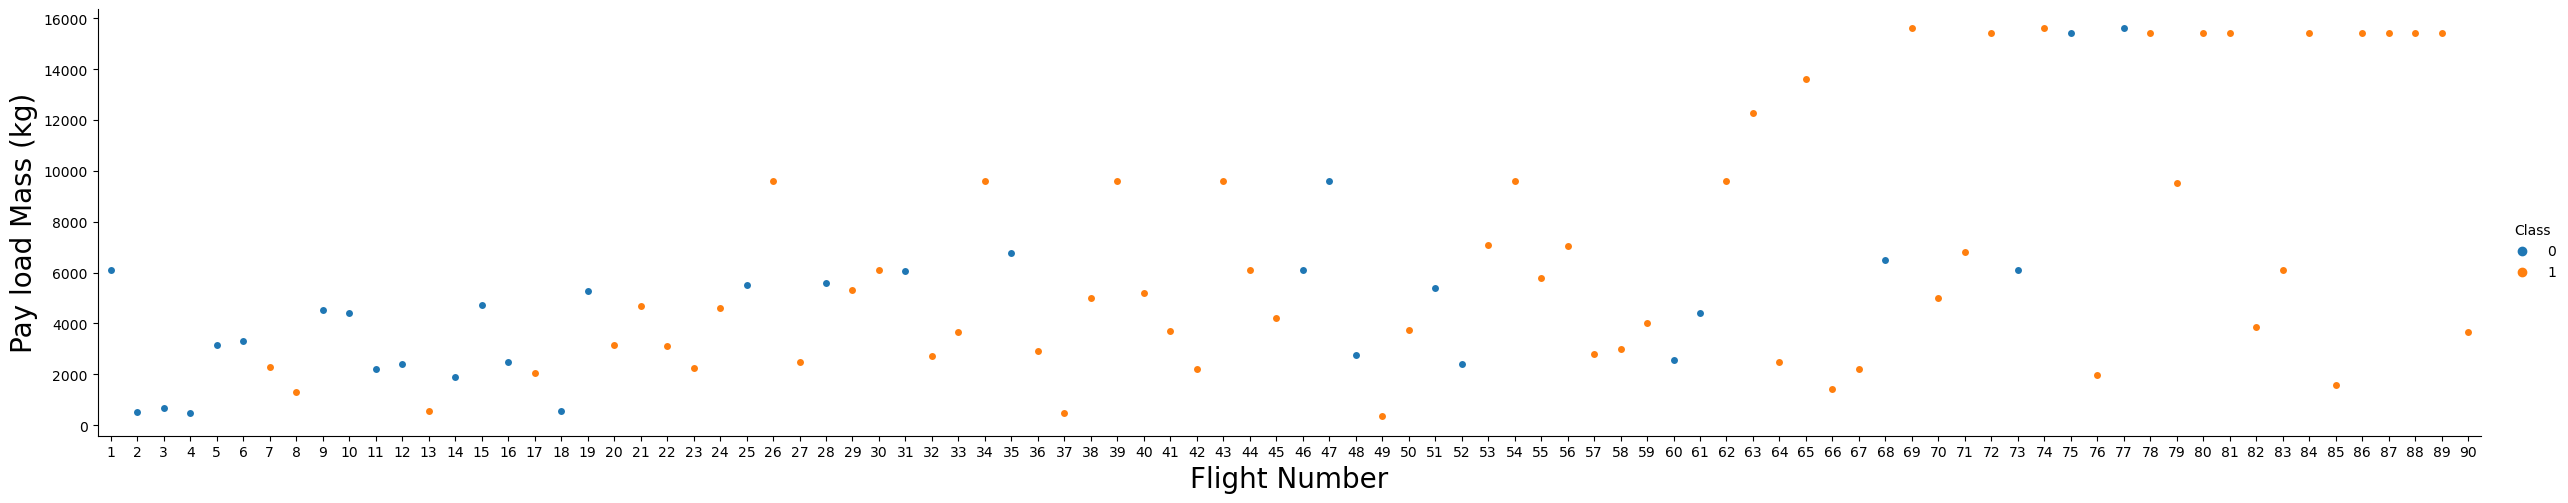

In [56]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

We see that different launch sites have different success rates.  <code>CCAFS LC-40</code>, has a success rate of 60 %, while  <code>KSC LC-39A</code> and <code>VAFB SLC 4E</code> has a success rate of 77%.

**Visualizing the Relationship between Flight Number and Launch Site:**

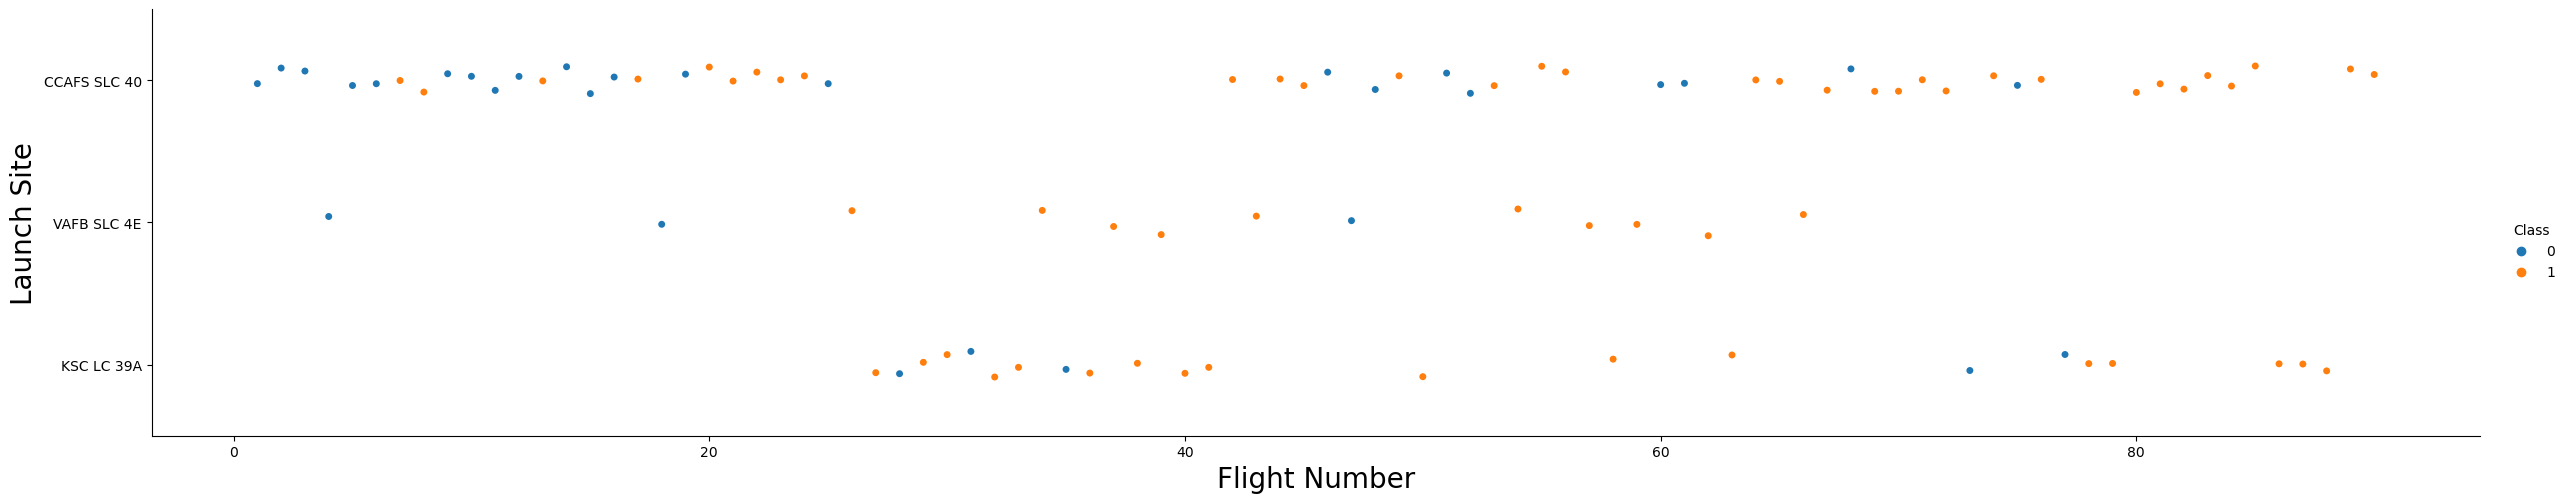

In [57]:
sns.catplot(x='FlightNumber', y='LaunchSite', hue='Class', data=df, aspect=5)
plt.xlabel('Flight Number', fontsize=20)
plt.ylabel('Launch Site', fontsize=20)
plt.show()

- The earliest flights all failed while the latest flights all succeeded.
- The CCAFS SLC 40 launch site has about a half of all launches.
- VAFB SLC 4E and KSC LC 39A have higher success rates.
- It can be assumed that each new launch has a higher rate of success.

**Visualizing the Relationship between Payload and Launch Site:**

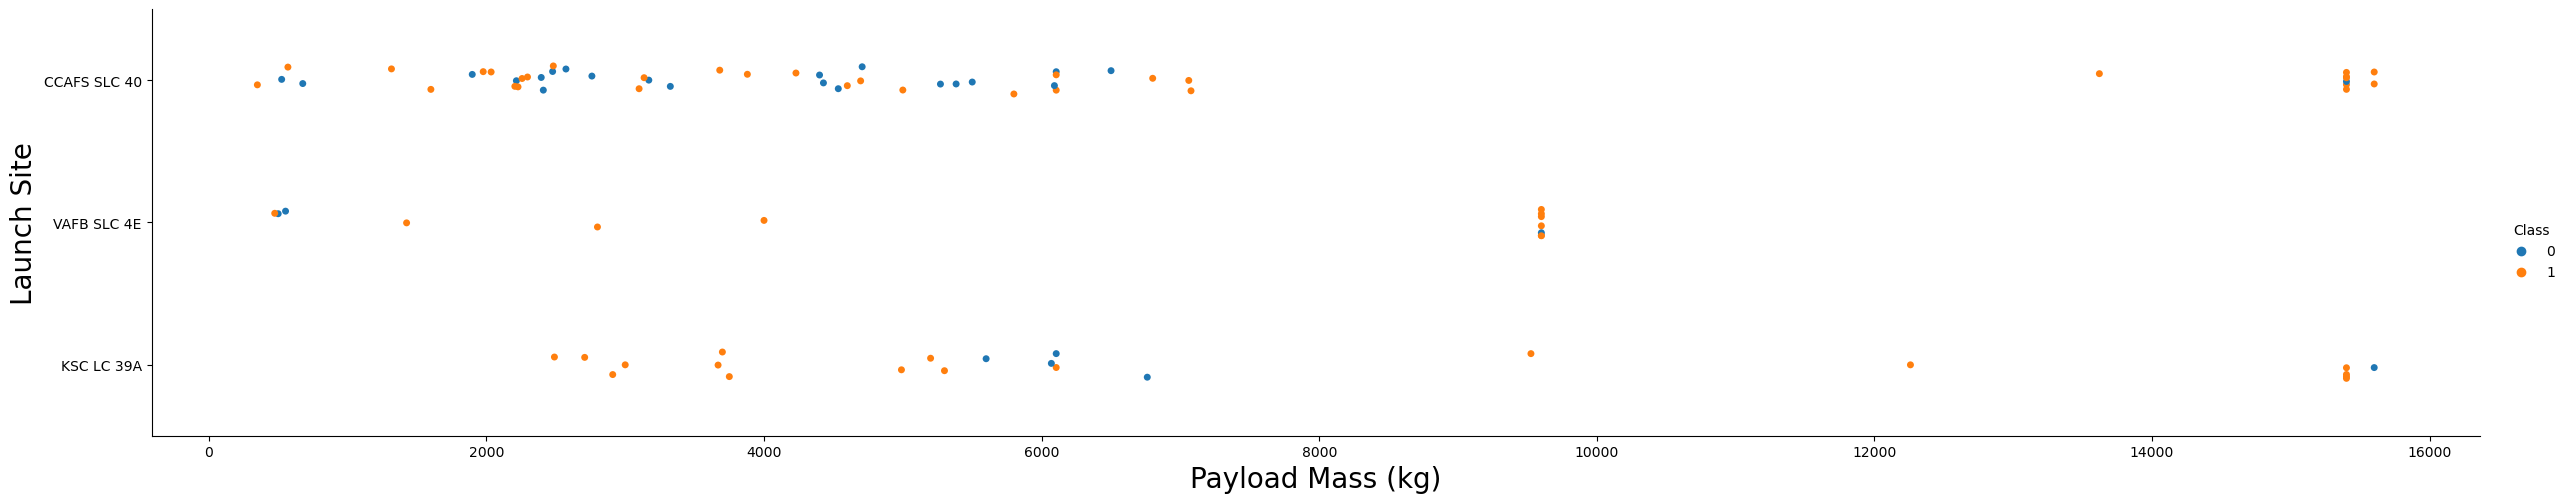

In [58]:
sns.catplot(x='PayloadMass', y='LaunchSite', hue='Class', data=df, aspect = 5)
plt.xlabel('Payload Mass (kg)',fontsize=20)
plt.ylabel('Launch Site',fontsize=20)
plt.show()

- For every launch site the higher the payload mass, the higher the success rate.
- Most of the launches with payload mass over 7000 kg were successfull.
- KSC LC 39A has a 100% success rate for payload mass under 5500 kg too.
- For the VAFB-SLC launchsite there are no rockets launched for heavypayload mass(greater than 10000)

**Visualizing the Relationship between Success Rate of each Orbit Type:**

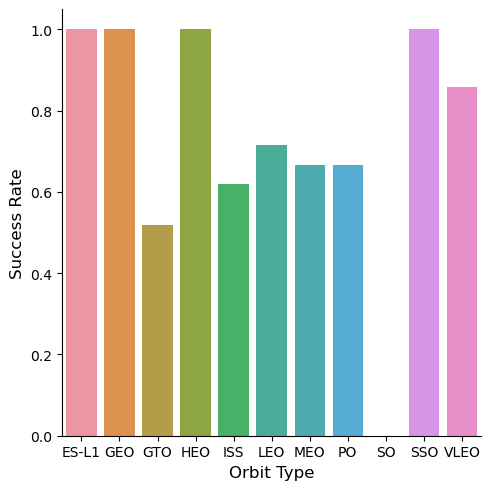

In [59]:
sns.catplot(x= 'Orbit', y = 'Class', data = df.groupby('Orbit')['Class'].mean().reset_index(), kind = 'bar')
plt.xlabel('Orbit Type',fontsize=12)
plt.ylabel('Success Rate',fontsize=12)
plt.show()

- Orbits with 100% success rate are: *ES-L1, GEO, HEO, SSO*

- Orbits with 0% success rate are: *SO*

- Orbits with success rate between 50% and 85%: *GTO, ISS, LEO, MEO, PO*

**Visualizing the Relationship between FlightNumber and Orbit Type:**

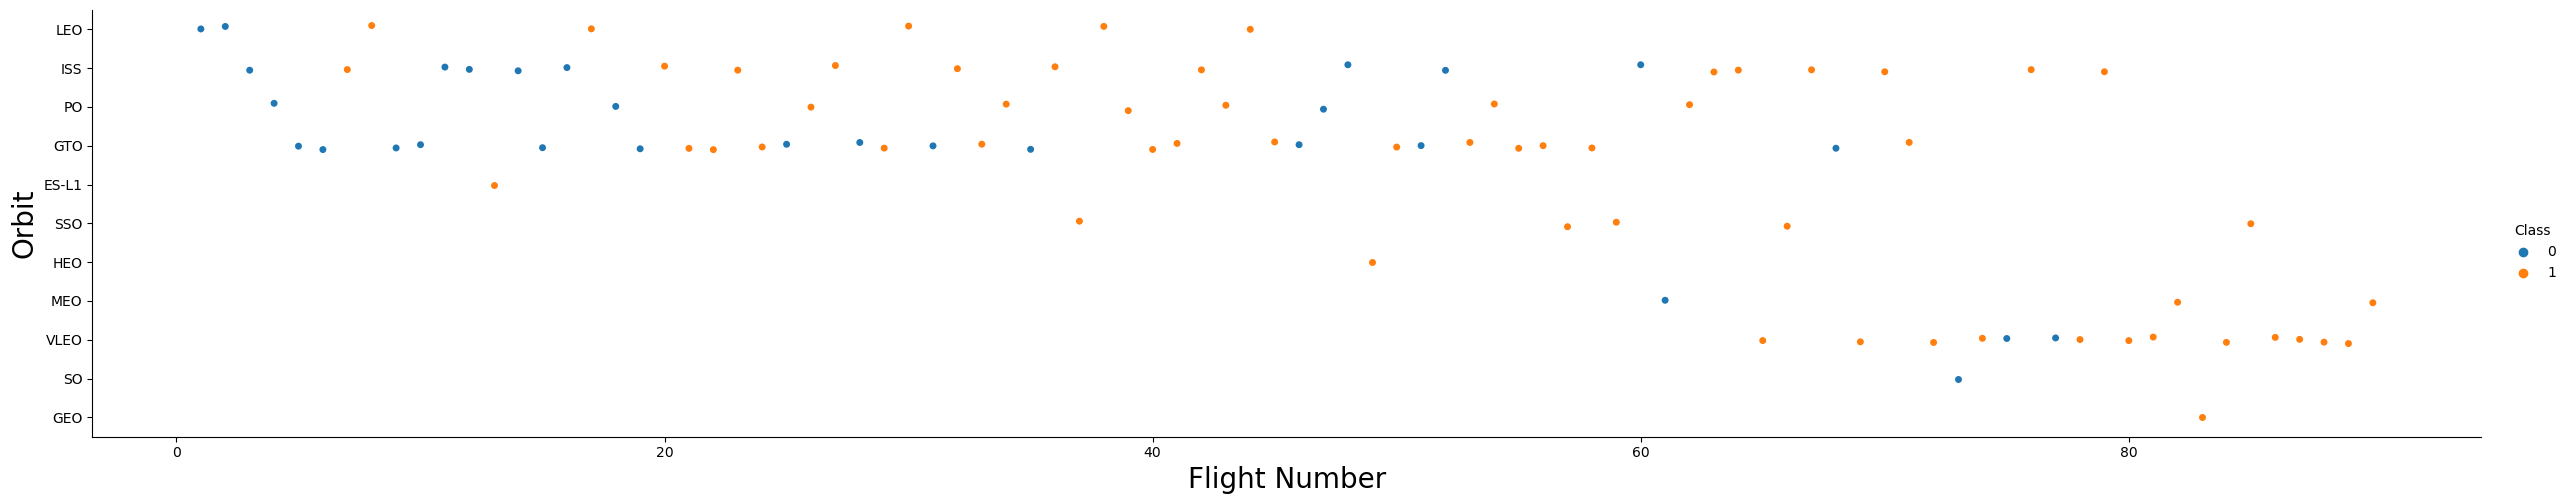

In [60]:
sns.catplot(x = 'FlightNumber', y = 'Orbit', hue = 'Class', data = df, aspect = 5)
plt.xlabel('Flight Number', fontsize = 20)
plt.ylabel('Orbit', fontsize = 20)
plt.show()

You should see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.

**Visualizing the Relationship between Payload and Orbit Type:**

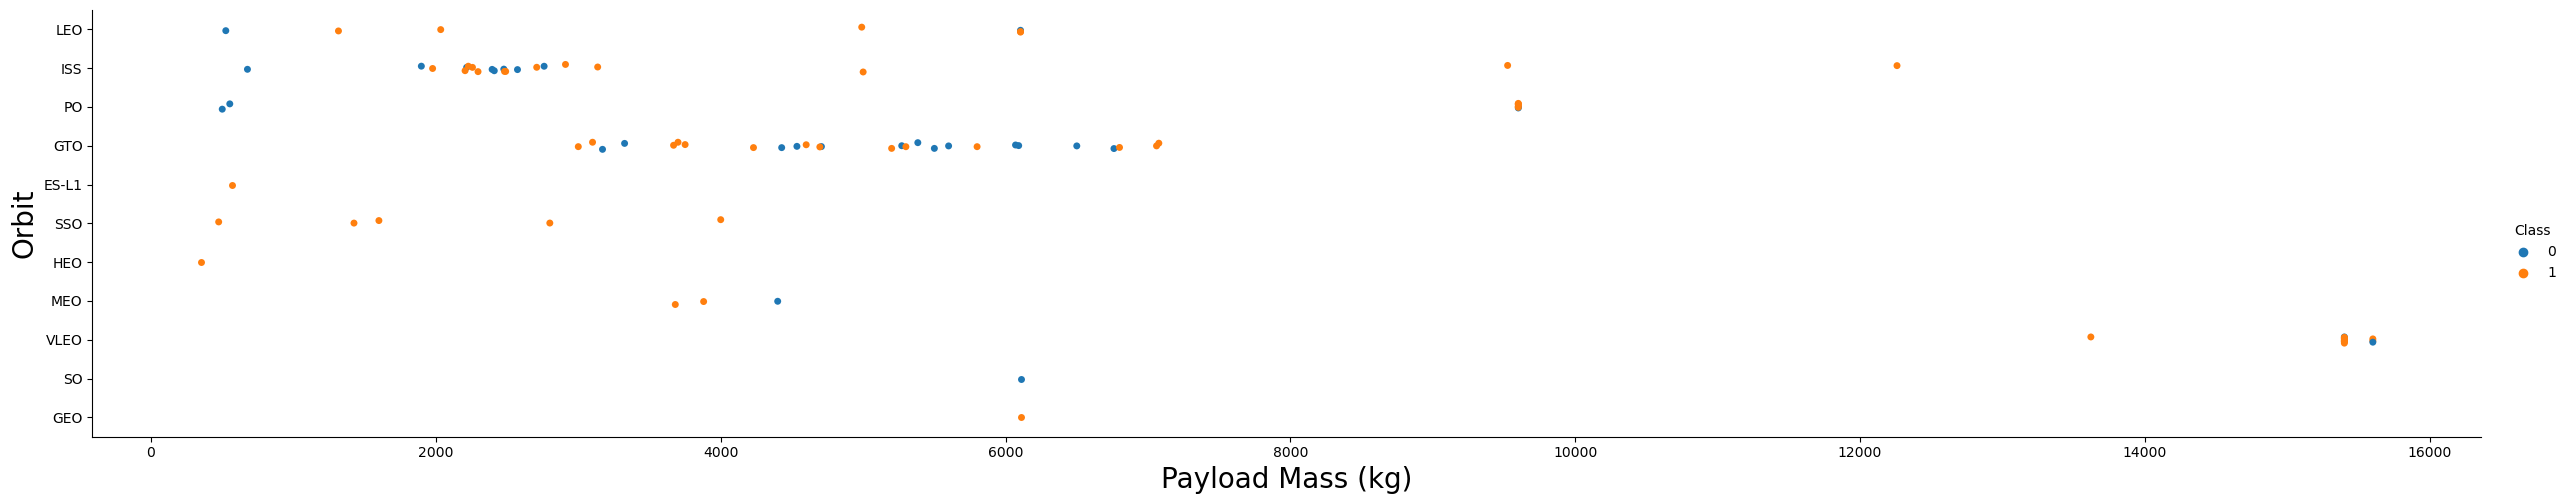

In [61]:
sns.catplot(x = 'PayloadMass', y = 'Orbit', hue = 'Class', data = df, aspect = 5)
plt.xlabel('Payload Mass (kg)', fontsize = 20)
plt.ylabel('Orbit', fontsize = 20)
plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS. However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.

**Visualizing the Launch Success Yearly Trend:**

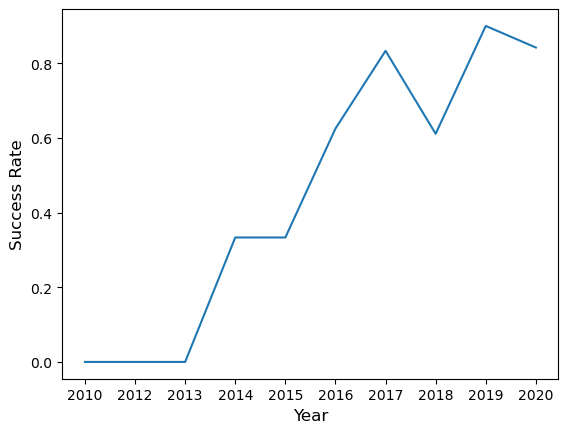

In [62]:
year=[]
def Extract_year(date):
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
years = df.groupby(Extract_year(df['Date'])).mean()['Class']
sns.lineplot(x = years.index, y = years)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Success Rate', fontsize = 12)
plt.show()

You can observe that the sucess rate since 2013 kept increasing till 2020.

## Feature Engineering:

By now, we have obtained some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction in the future module.

In [63]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


Performing One Hot Encoding:

In [64]:
features_one_hot = pd.get_dummies(features[['Orbit', 'LaunchSite', 'LandingPad', 'Serial']])
features_one_hot.head()

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
features_one_hot.astype('float64').head()

,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*Run the cell below, if you wish to download your dataset:*

In [66]:
df.to_csv('features_one_hot.csv', index=False)
FileLink('features_one_hot.csv')

C:\Users\Fouzan Akhter\features_one_hot.csv

## Interactive Visual Analytics:

The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.

**Marking all Launch Sites on a Map:**

The dataset named `spacex_launch_geo.csv` is an augmented dataset with latitude and longitude added for each site.

In [67]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv"
response = requests.get(URL)
response.raise_for_status()
spacex_df = pd.read_csv(io.StringIO(response.text))
spacex_df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of BrouÃ¨re cheese",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


What are the coordinates for each site ?

In [68]:
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.

**MAP-1**

In [69]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
marker = folium.map.Marker(
    nasa_coordinate,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

**MAP-2**

In [70]:
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
for launch_site, site_lat, site_long in zip(launch_sites_df['Launch Site'], launch_sites_df['Lat'], launch_sites_df['Long']):
    site_coordinate = [site_lat, site_long]
    circle = folium.Circle(site_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(launch_site))
    marker = folium.map.Marker(
        site_coordinate,
        icon=DivIcon(
            icon_size=(20, 20),
            icon_anchor=(0, 0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % launch_site,
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)
site_map

Most of the launch sites considered in this project are located near the Equator. Launch sites are positioned as close to the Equator as possible because objects on Earth's surface at the Equator move at the highest speed (1670 kilometers per hour). Launching from the Equator provides an additional boost of nearly 500 km/hour to the spacecraft compared to launching from a location halfway to the North Pole. Additionally, all the launch sites in this project are situated close to the coast. Launching rockets over the ocean minimizes the risk of debris falling or exploding near populated areas, ensuring greater safety for people.

**Marking the Success / Failed Launches for each Site on the Map:**

In [71]:
marker_cluster = MarkerCluster()
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)

**MAP-3**

In [72]:
site_map.add_child(marker_cluster)
for site_lat, site_long, marker_color in zip(spacex_df['Lat'], spacex_df['Long'], spacex_df['marker_color']):
    site_coordinate = [site_lat, site_long]
    marker = folium.map.Marker(
        site_coordinate,
        # Create an icon as a text label
        icon=folium.Icon(color='white', 
                         icon_color=marker_color))
    marker.add_to(marker_cluster)
site_map

**Calculating the Distances between a Launch Site to its Proximities:**

**MAP-4**

In [73]:
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,)
site_map.add_child(mouse_position)
site_map

In [74]:
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [75]:
railway_marker = [28.55752, -80.80155]
launch_coordinate = [28.57337, -80.64669]
distance_railway = calculate_distance(railway_marker[0], railway_marker[1], launch_coordinate[0], launch_coordinate[1])
distance_railway

15.230651245141603

**MAP-5**

In [76]:
marker = folium.map.Marker(
        railway_marker,
        icon=DivIcon(
            icon_size=(400, 400),
            icon_anchor=(0, 0),
            html='<div style="font-size:400; color:#0c10f2;"><b>%s</b></div>' % str(round(distance_railway, 2))+' km',))
marker.add_to(site_map)
site_map

**MAP-6**

In [77]:
folium.PolyLine([railway_marker, launch_coordinate], color='blue').add_to(site_map)
site_map

In [78]:
city   = [28.61200, -80.80788]
coastline = [28.5858, -80.79952]
highway   = [28.5402, -80.85079]
city_distance = calculate_distance(city[0], city[1], launch_coordinate[0], launch_coordinate[1])
coastline_distance = calculate_distance(coastline[0], coastline[1], launch_coordinate[0], launch_coordinate[1])
highway_distance = calculate_distance(highway[0], highway[1], launch_coordinate[0], launch_coordinate[1])
colors = ['red','orange','green']
html_colors = ['#dc3545','#fd7e14','#198754']
for coordinate ,distance, color, html_color in zip([city, coastline, highway], [city_distance, coastline_distance, highway_distance], colors, html_colors):
    marker = folium.map.Marker(
            coordinate,
            # Create an icon as a text label
            icon=DivIcon(
                icon_size=(20,20),
                icon_anchor=(0,0),
                html='<div style="font-size: 12; color:'+html_color+';"><b>%s</b></div>' % str(round(distance, 2)) + 'km',))
    marker.add_to(site_map)
    folium.PolyLine([coordinate, launch_coordinate], color=color).add_to(site_map)
site_map

## Creating a Dashboard for Visualizations using Jupyter-Dash

In [79]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv"
response = requests.get(URL)
response.raise_for_status()
spacex_df = pd.read_csv(io.StringIO(response.text))
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()
app = JupyterDash(__name__)
app.layout = html.Div(children=[
    html.H1('SpaceX Launch Records Dashboard',
            style={'textAlign': 'center', 'color': '#503D36', 'font-size': 40}),
    dcc.Dropdown(id='site-dropdown',
                 options=[
                     {'label': 'All Sites', 'value': 'All Sites'},
                     {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                     {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                     {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                     {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'}
                 ],
                 placeholder='Select a Launch Site Here',
                 value='All Sites',
                 searchable=True
                 ),
    html.Br(),
    html.Div(dcc.Graph(id='success-pie-chart')),
    html.Br(),
    html.P("Payload range (Kg):"),
    dcc.RangeSlider(id='payload-slider',
                    min=0,
                    max=10000,
                    step=1000,
                    marks={i: '{}'.format(i) for i in range(0, 10001, 1000)},
                    value=[min_payload, max_payload]),
    html.Div(dcc.Graph(id='success-payload-scatter-chart')),
])
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(launch_site):
    if launch_site == 'All Sites':
        fig = px.pie(values=spacex_df.groupby('Launch Site')['class'].mean(), 
                     names=spacex_df.groupby('Launch Site')['Launch Site'].first(),
                     title='Total Success Launches by Site')
    else:
        fig = px.pie(values=spacex_df[spacex_df['Launch Site'] == launch_site]['class'].value_counts(normalize=True), 
                     names=spacex_df['class'].unique(), 
                     title='Total Success Launches for Site {}'.format(launch_site))
    return fig
@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
              [Input(component_id='site-dropdown', component_property='value'),
               Input(component_id='payload-slider', component_property='value')])
def get_payload_chart(launch_site, payload_mass):
    if launch_site == 'All Sites':
        fig = px.scatter(spacex_df[spacex_df['Payload Mass (kg)'].between(payload_mass[0], payload_mass[1])], 
                         x="Payload Mass (kg)",
                         y="class",
                         color="Booster Version Category",
                         hover_data=['Launch Site'],
                         title='Correlation Between Payload and Success for All Sites')
    else:
        df = spacex_df[spacex_df['Launch Site'] == launch_site]
        fig = px.scatter(df[df['Payload Mass (kg)'].between(payload_mass[0], payload_mass[1])], 
                         x="Payload Mass (kg)",
                         y="class",
                         color="Booster Version Category",
                         hover_data=['Launch Site'],
                         title='Correlation Between Payload and Success for Site {}'.format(launch_site))
    return fig
app.run_server(mode='inline')

## Machine Learning Prediction:

**Defining function to plot Confusion Matrix:**

In [80]:
def plot_confusion_matrix(y,y_predict):
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax);
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Did Not Land', 'Did Land']); ax.yaxis.set_ticklabels(['Did Not Land', 'Did Land']) 
    plt.show() 

**Continuing with the Previous Two Datasets:**

In [81]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
response = requests.get(URL)
response.raise_for_status()
data = pd.read_csv(io.StringIO(response.text))
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [82]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"
response = requests.get(URL)
response.raise_for_status()
X = pd.read_csv(io.StringIO(response.text))
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [83]:
Y = pd.Series(data['Class'].to_numpy())
Y.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    0
dtype: int64

**Standard Scaling the Dataset:**

In [84]:
transform = preprocessing.StandardScaler()
X = transform.fit(X).transform(X)

**Performing Train Test Split:**

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
Y_test.shape

(18,)

**Applying Logistic Regression Algorithm for Prediction:**

In [86]:
%%time
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}
lr=LogisticRegression()
logreg_cv=GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

CPU times: total: 141 ms
Wall time: 183 ms


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [87]:
print("Tuned Hyper-Parameters:", logreg_cv.best_params_)
print("Accuracy :",logreg_cv.best_score_)

Tuned Hyper-Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8464285714285713


Computing Accuracy on Test Data (LogReg):

In [88]:
logreg_accuracy = logreg_cv.score(X_test, Y_test)
logreg_accuracy

0.8333333333333334

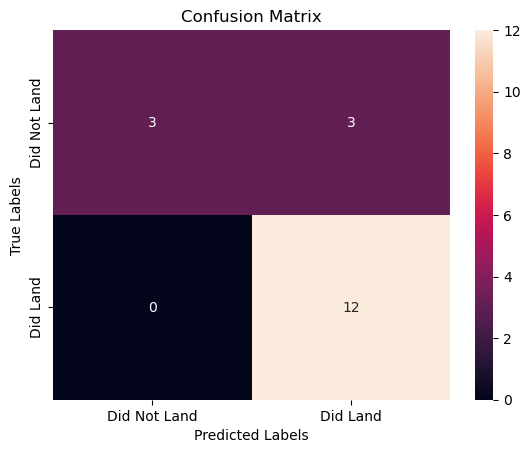

In [89]:
logreg_yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, logreg_yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes. We see that the major problem is false positives.

**Applying Support Vector Machine for Prediction:**

In [90]:
%%time
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

CPU times: total: 3.02 s
Wall time: 3.33 s


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [91]:
print("Tuned Hyper-Parameters:",svm_cv.best_params_)
print("Accuracy :",svm_cv.best_score_)

Tuned Hyper-Parameters: {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy : 0.8482142857142856


Computing Accuracy on Test Data (SVM):

In [92]:
svm_accuracy = svm_cv.score(X_test, Y_test)
svm_accuracy

0.8333333333333334

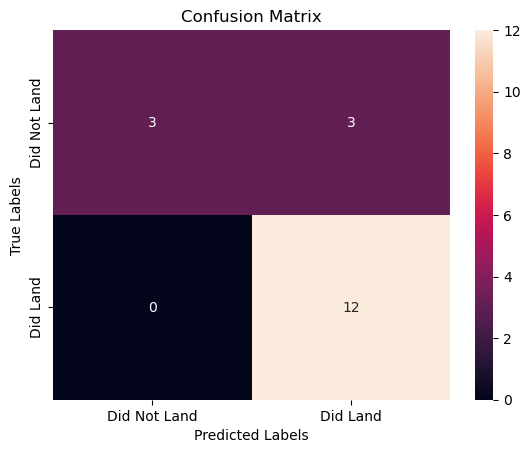

In [93]:
svm_yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, svm_yhat)

**Applying Decision Trees Algorithm for Prediction:**

In [94]:
%%time
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

CPU times: total: 9.56 s
Wall time: 10.3 s


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [95]:
print("Tuned Hyper-Parameters:", tree_cv.best_params_)
print("Accuracy :", tree_cv.best_score_)

Tuned Hyper-Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
Accuracy : 0.875


Computing Accuracy on Test Data (D-Trees):

In [96]:
tree_accuracy = tree_cv.score(X_test, Y_test)
tree_accuracy

0.8333333333333334

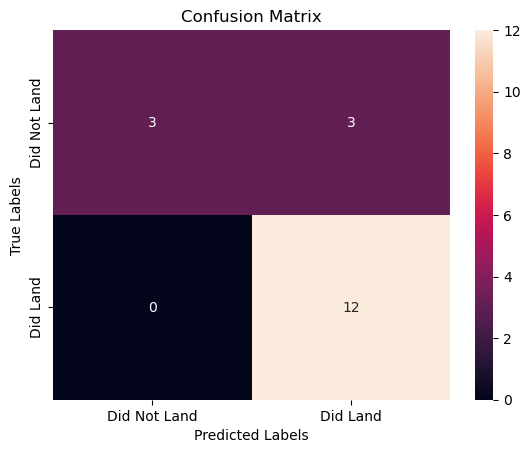

In [97]:
tree_yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, tree_yhat)

**Applying KNN Algorithm for Prediction:**

In [98]:
%%time
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

CPU times: total: 39.4 s
Wall time: 20.6 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [99]:
print("Tuned Hyper-Parameters:", knn_cv.best_params_)
print("Accuracy :", knn_cv.best_score_)

Tuned Hyper-Parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Accuracy : 0.8482142857142858


Computing Accuracy on Test Data (KNN):

In [100]:
knn_accuracy = knn_cv.score(X_test, Y_test)
knn_accuracy

0.8333333333333334

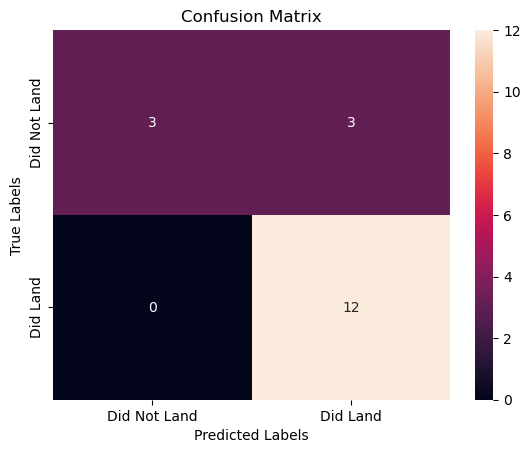

In [101]:
knn_yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, knn_yhat)

**Visualizing Results in a DataFrame:**

In [105]:
jaccard_scores = [
                  jaccard_score(Y_test, logreg_yhat, average='binary'),
                  jaccard_score(Y_test, svm_yhat, average='binary'),
                  jaccard_score(Y_test, tree_yhat, average='binary'),
                  jaccard_score(Y_test, knn_yhat, average='binary'),
                 ]

f1_scores = [
             f1_score(Y_test, logreg_yhat, average='binary'),
             f1_score(Y_test, svm_yhat, average='binary'),
             f1_score(Y_test, tree_yhat, average='binary'),
             f1_score(Y_test, knn_yhat, average='binary'),
            ]

accuracy = [logreg_accuracy, svm_accuracy, tree_accuracy, knn_accuracy]

results_df = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]), index=['Jaccard Score',
                                                                              'F1 Score',
                                                                              'Accuracy Score'] , columns=['LogReg',
                                                                                                     'SVM',
                                                                                                     'Tree',
                                                                                                     'KNN'])
results_df

,LogReg,SVM,Tree,KNN
Jaccard Score,0.800000,0.800000,0.800000,0.800000
F1 Score,0.888889,0.888889,0.888889,0.888889
Accuracy Score,0.833333,0.833333,0.833333,0.833333


Results from the Complete Dataset Trained on Models:

In [106]:
jaccard_scores = [
                  jaccard_score(Y, logreg_cv.predict(X), average='binary'),
                  jaccard_score(Y, svm_cv.predict(X), average='binary'),
                  jaccard_score(Y, tree_cv.predict(X), average='binary'),
                  jaccard_score(Y, knn_cv.predict(X), average='binary'),
                 ]

f1_scores = [
             f1_score(Y, logreg_cv.predict(X), average='binary'),
             f1_score(Y, svm_cv.predict(X), average='binary'),
             f1_score(Y, tree_cv.predict(X), average='binary'),
             f1_score(Y, knn_cv.predict(X), average='binary'),
            ]

accuracy = [logreg_cv.score(X, Y), svm_cv.score(X, Y), tree_cv.score(X, Y), knn_cv.score(X, Y)]

results = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]),
                      index=['Jaccard Score', 'F1 Score', 'Accuracy Score'],
                      columns=['LogReg', 'SVM', 'Tree', 'KNN'])
results

,LogReg,SVM,Tree,KNN
Jaccard Score,0.833333,0.845070,0.810811,0.819444
F1 Score,0.909091,0.916031,0.895522,0.900763
Accuracy Score,0.866667,0.877778,0.844444,0.855556


<p style="text-align: center;"><strong>Further Discussions in the PowerPoint Presentation</strong></p>
